# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%%capture
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque, namedtuple
from itertools import count

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [2]:
env = UnityEnvironment(file_name='./Reacher.app', no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


Policy Network and Critic Network. Policy Network takes the current states and outputs actions, while the Critic measures how valuable the current state is.

In [12]:
class Policy(nn.Module):
    def __init__(self, input_dim, action_dim, h=(64,32,16)):
        super(Policy, self).__init__()
        nodes = (input_dim,)+h+(action_dim,)
        self.fc_mu = nn.ModuleList([nn.Linear(x,y) for x,y in zip(nodes[:-1], nodes[1:])])
        
    def forward(self, x):
        for layer in self.fc_mu[:-1]:
            x = F.relu(layer(x))
            
        return torch.tanh(self.fc_mu[-1](x))
    
class Critic(nn.Module):
    def __init__(self, input_dim, action_dim, h1=(64,), h2=(32,16,8)):
        super(Critic, self).__init__()
        nodes1 = (input_dim,)+h1
        self.fc1 = nn.ModuleList([nn.Linear(x,y) for x,y in zip(nodes1[:-1], nodes1[1:])])
        nodes2 = h1[:-1] + (h1[-1] + action_dim,) + h2 + (1,)
        self.fc2 = nn.ModuleList([nn.Linear(x,y) for x,y in zip(nodes2[:-1], nodes2[1:])])
        
    def forward(self, x, action):
        for layer in self.fc1:
            x = F.relu(layer(x))
        
        x = torch.cat([x, action], dim=-1)
        for layer in self.fc2[:-1]:
            x = F.relu(layer(x))
            
        return self.fc2[-1](x)    

In [13]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, priority=False):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.error_buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
#         self.seed = random.seed(seed)
        self.priority = priority
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.error_buffer.append(0.0) #placeholder of zero
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        idx = np.random.choice(len(self.memory), self.batch_size, replace=False)
            # experiences = random.sample(self.memory, k=self.batch_size)
        experiences = [self.memory[i] for i in idx]

        states = torch.from_numpy(np.stack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.stack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [18]:
BUFFER_SIZE = int(5e3)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 1e-4               # learning rate 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            

class DDPGAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, n, state_size, action_size, priority=False):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.num_agents = n
        self.state_size = state_size
        self.action_size = action_size

        # Q-Network
        self.qnetwork_local = Critic(state_size, action_size).to(device)
        self.qnetwork_target = Critic(state_size, action_size).to(device)
        self.q_optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        
        self.policy_local = Policy(state_size, action_size).to(device)
        self.policy_target = Policy(state_size, action_size).to(device)
        self.policy_optimizer = optim.Adam(self.policy_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, priority)
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

    def act(self, state, noise):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.policy_local.eval()
        with torch.no_grad():
            action_values = self.policy_local(state)
        self.policy_local.train()
        
        action_values += noise * torch.randn(self.num_agents, self.action_size).to(device)
        action_values = torch.clamp(action_values, -1, 1)
        return action_values #.squeeze()

    def learn(self):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = self.memory.sample()
        
        target = self.qnetwork_target(next_states, self.policy_target(next_states))
        target = rewards.unsqueeze(-1) + GAMMA * target
        y = self.qnetwork_local(states, actions)
        critic_loss = 0.5*(y - target.detach()).pow(2.0).sum(1).mean()
        
        self.q_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)
        self.q_optimizer.step()
        
        action = self.policy_local(states)
        policy_loss = -self.qnetwork_local(states, action).mean()

        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_local.parameters(), 1)
        self.policy_optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)  
        self.soft_update(self.policy_local, self.policy_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data) 

In [15]:
episode = 500
discount_rate = .99
noise = 0.1
noise_decay = 0.99
tmax = 2500

# keep track of progress
mean_rewards = []

agent = DDPGAgent(num_agents, state_size, action_size)

for e in range(episode):
#     import pdb; pdb.set_trace()
    env_info = env.reset(train_mode=True)[brain_name]
    sum_rewards = 0
    for t in count():
        states = env_info.vector_observations         # get next state (for each agent)
        actions = agent.act(states, noise)
        env_info = env.step(actions.cpu().numpy().squeeze())[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        agent.step(states, actions, rewards, next_states, dones)
        sum_rewards += np.array(rewards)
        
        if len(agent.memory) > BATCH_SIZE and (t+1) % 20 == 0:
            for _ in range(10):
                agent.learn()
        
        if np.any(dones):
            break
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(sum_rewards))
    noise = noise * noise_decay
    
    # display some progress every 20 iterations
    if e % (episode // 20) ==0:
        print("Episode: {0:d}, average score: {1:f}".format(e+1,np.mean(mean_rewards[-50:])))

Episode: 1, average score: 0.950000
Episode: 26, average score: 0.796154
Episode: 51, average score: 1.278000
Episode: 76, average score: 1.708600
Episode: 101, average score: 1.796600
Episode: 126, average score: 1.834800
Episode: 151, average score: 1.447400
Episode: 176, average score: 0.857400
Episode: 201, average score: 0.318800


KeyboardInterrupt: 

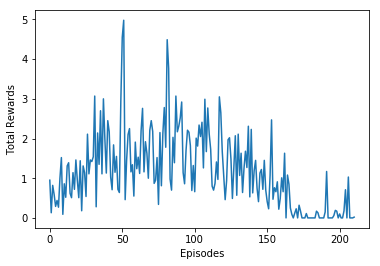

In [17]:
plt.plot(mean_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.savefig('mean_rewards')
plt.show()

In [ ]:
env.close()